In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from src.data.datasets import DataModule

from tsl.datasets import MetrLA, AirQuality, PemsBay

import numpy as np
from sklearn import datasets


from evidently.report import Report
from evidently.metrics import DataDriftTable
from evidently.metrics import DatasetDriftMetric

from tsl.ops.imputation import add_missing_values

from sklearn.preprocessing import MinMaxScaler

/home/javier/anaconda3/envs/tsl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/javier/anaconda3/envs/tsl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/javier/anaconda3/envs/tsl/lib/python3.10/site-packages/umap/distances.

In [2]:
def load_tensors(file_name):
    with open(file_name, 'rb') as f:
        outputs = pickle.load(f)
        
    for i in range(len(outputs)):
        if i == 0:
            x_real = outputs[i]['x_real']
            x_fake = outputs[i]['x_fake']
            d_pred = outputs[i]['d_pred']
            imputation = outputs[i]['imputation']
            input_mask_int = outputs[i]['input_mask_int']
            input_mask_bool = outputs[i]['input_mask_bool']
            known_values = outputs[i]['known_values']
        else:
            x_real = torch.cat([x_real, outputs[i]['x_real']], dim=0)
            x_fake = torch.cat([x_fake, outputs[i]['x_fake']], dim=0)
            d_pred = torch.cat([d_pred, outputs[i]['d_pred']], dim=0)
            imputation = torch.cat([imputation, outputs[i]['imputation']], dim=0)
            input_mask_int = torch.cat([input_mask_int, outputs[i]['input_mask_int']], dim=0)
            input_mask_bool = torch.cat([input_mask_bool, outputs[i]['input_mask_bool']], dim=0)
            known_values = torch.cat([known_values, outputs[i]['known_values']], dim=0)
            
    return x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values
    
def get_report(train, test):

    data_drift_dataset_report = Report(metrics=[

    DatasetDriftMetric(),

    DataDriftTable(),    

    ])

    df_train_x = pd.DataFrame(train)
    df_test_x = pd.DataFrame(test)

    df_train_x.columns = ['x']
    df_test_x.columns = ['x']

    data_drift_dataset_report.run(
    reference_data=df_train_x,
    current_data=df_test_x,
    )

    print(data_drift_dataset_report.json())
    
def get_values(dataloader):
    for i, batch in enumerate(dataloader):
        x, x_real, input_mask_bool, input_mask_int, known_values, time_gap_matrix = batch
        if i == 0:
            res = x_real.cpu().detach().numpy()
        else:
            res = np.concatenate([res, x_real.cpu().detach().numpy()])
    
    return res.flatten()

def plot_dist(data):
    plt.figure()
    sns.histplot(data=data, stat='count', common_norm=False)
    plt.title('Histograma de los valores reales')
    plt.xlabel('Valores reales')
    plt.show()

def plot_results(train, test):
    df1 = pd.DataFrame({'x': train, 'type': ['train' for _ in range(len(train))]})
    df2 = pd.DataFrame({'x': test, 'type': ['test' for _ in range(len(test))]})

    df = pd.concat([df1, df2], axis=0)

    plt.figure()
    sns.histplot(data=df, x='x', hue='type', stat='count', common_norm=False)
    plt.title('Histograma de los valores de train y de test')
    plt.xlabel('Valores reales')
    plt.show()

def plot_norm_denorm(norm, denorm):
    df1 = pd.DataFrame({'x': norm, 'type': ['norm' for _ in range(len(norm))]})
    df2 = pd.DataFrame({'x': denorm, 'type': ['denorm' for _ in range(len(denorm))]})

    df = pd.concat([df1, df2], axis=0)

    plt.figure()
    sns.histplot(data=df, x='x', hue='type', stat='count', common_norm=False)
    plt.title('Histograma de los valores normalizados y desnormalizados')

    plt.show()
    
def load_tensors_denorm(file_name):
    with open(file_name, 'rb') as f:
        outputs = pickle.load(f)

    for i in range(len(outputs)):
        if i == 0:
            x_real = outputs[i]['real']
            x_fake = outputs[i]['fake']
        else:
            x_real = np.concatenate([x_real, outputs[i]['real']])
            x_fake = np.concatenate([x_fake, outputs[i]['fake']])

    return x_real, x_fake

def get_values_norm(dataloader, normalizer):

    for i, batch in enumerate(dataloader):
        x, x_real, input_mask_bool, input_mask_int, known_values, time_gap_matrix = batch
        x_real = x_real.reshape(-1, 36)
        x_real_denorm = normalizer.inverse_transform(x_real.cpu().detach().numpy())
        x_real_denorm = x_real_denorm[~input_mask_bool.reshape(x_real_denorm.shape)]
        if i == 0:
            res = x_real_denorm
        else:
            res = np.concatenate([res, x_real_denorm])
        
    return res.flatten()

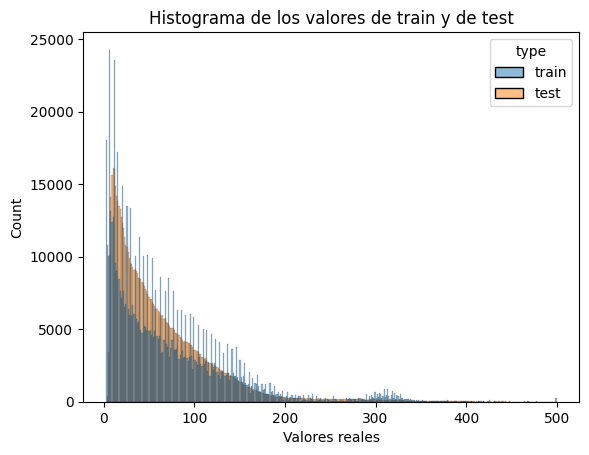

In [4]:
x_real_d, x_fake_d = load_tensors_denorm('outputs_test_denorm_h_0.2_air-36.pkl')
plot_results(x_real_d, x_fake_d)


(8759, 36)
Missing percentaje: 24.61


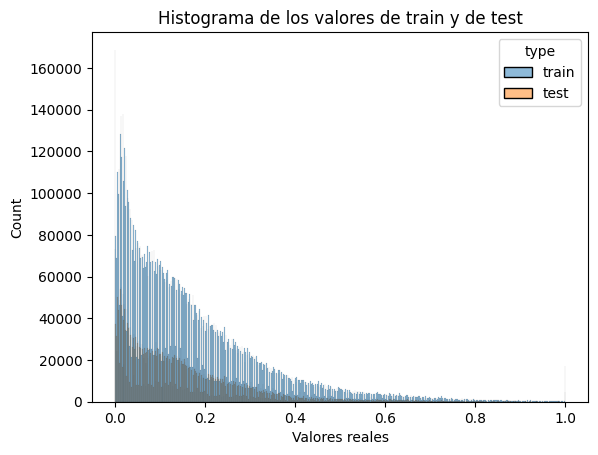

In [20]:
dm = DataModule(dataset='air-36_in')
dm.setup()


train_x = get_values(dm.train_dataloader())
test_x = get_values(dm.test_dataloader())

plot_results(train_x, test_x)

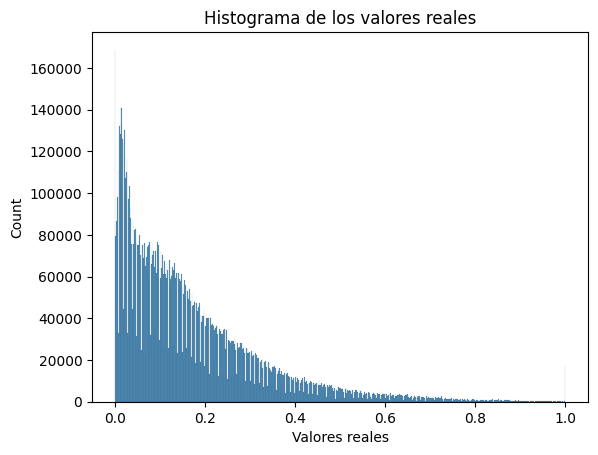

In [21]:
plot_dist(train_x)

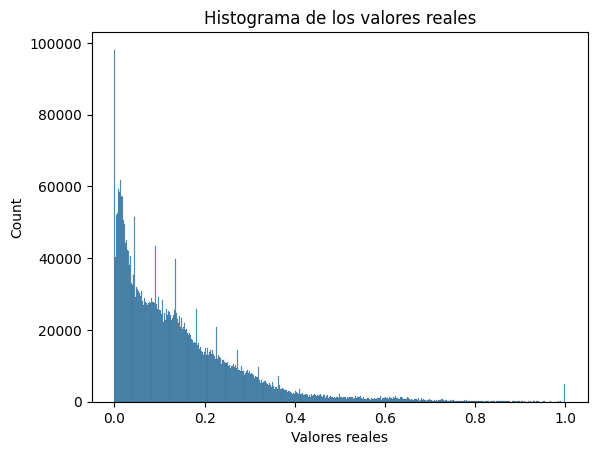

In [22]:
plot_dist(test_x)

In [23]:
print(train_x.shape, test_x.shape)

(11306304,) (3794688,)


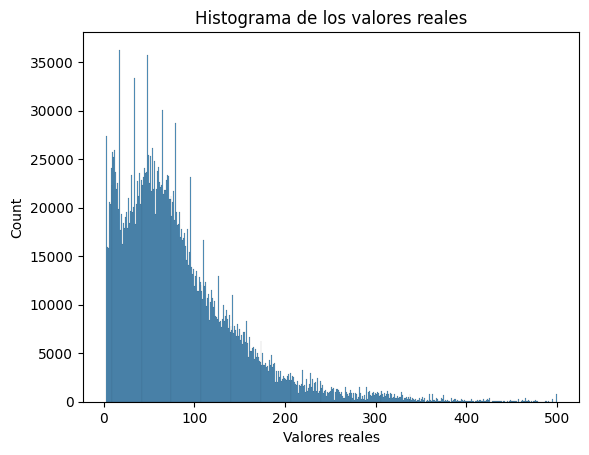

In [38]:
x_real_denorm = get_values_norm(dm.train_dataloader(), dm.get_normalizer())
plot_dist(x_real_denorm)

In [25]:
base_data = AirQuality(small=True)
mask = base_data.mask.reshape(-1, 36)
known_values = base_data.eval_mask
np_o_data = base_data.dataframe()[known_values].values.flatten()
mask.shape

(8759, 36)

In [26]:
get_report(np_o_data, x_real_denorm)

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.19662837589523166, "drift_detected": true, "current": {"small_distribution": {"x": [2.0, 51.79999923706055, 101.5999984741211, 151.39999389648438, 201.1999969482422, 251.0, 300.79998779296875, 350.6000061035156, 400.3999938964844, 450.20001220703125, 500.0], "y": [0.0074243017909573356, 0.006751368113596896, 0.0032585025460116364, 0.0014770955146713985, 0.0005915410726719978, 0.00027486141559536395, 0.00018548750287458452, 6.780429680312005e-05, 2.6758001114961077e-05, 

# Comparación entre datos originales, y datos originales desnormalizados

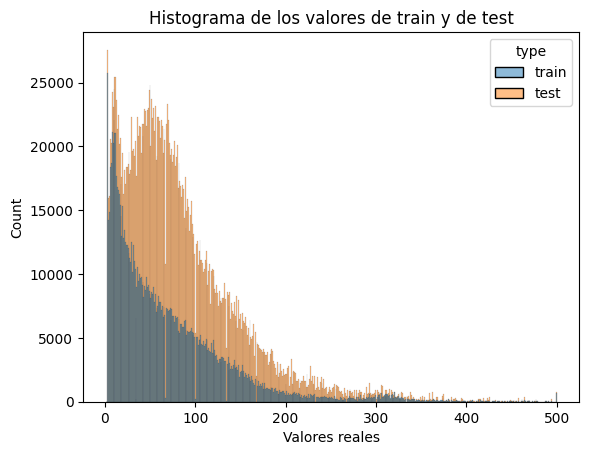

In [31]:
plot_results(np_o_data, x_real_denorm)

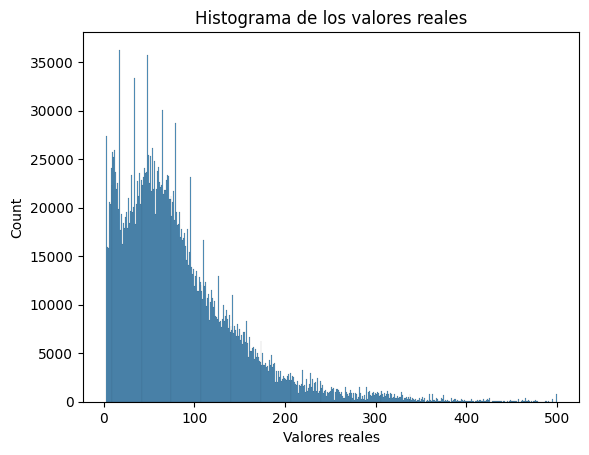

In [9]:
plot_dist(x_real_denorm)

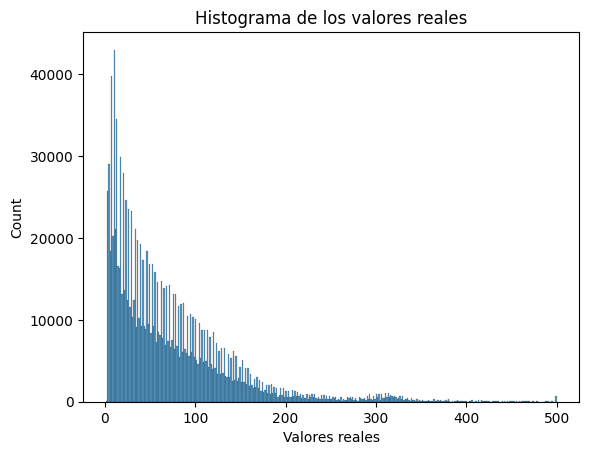

In [10]:
plot_dist(np_o_data)

# Comparación desnormalización salida modelos

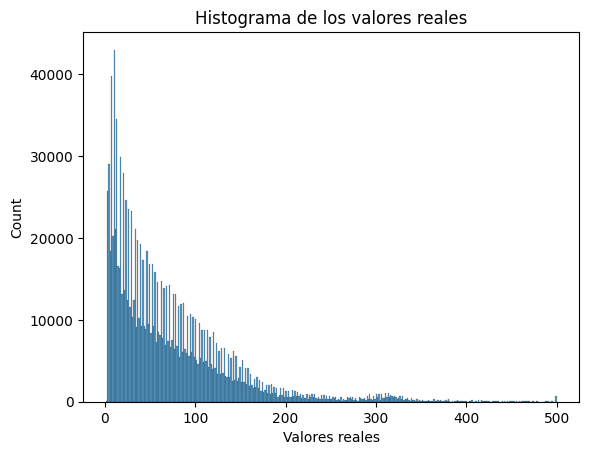

In [11]:
base_data = AirQuality(small=True)
mask = base_data.mask.reshape(-1, 36)
known_values = base_data.eval_mask.reshape(-1, 36)
np_o_data = base_data.dataframe()[known_values].values.flatten()
plot_dist(np_o_data)

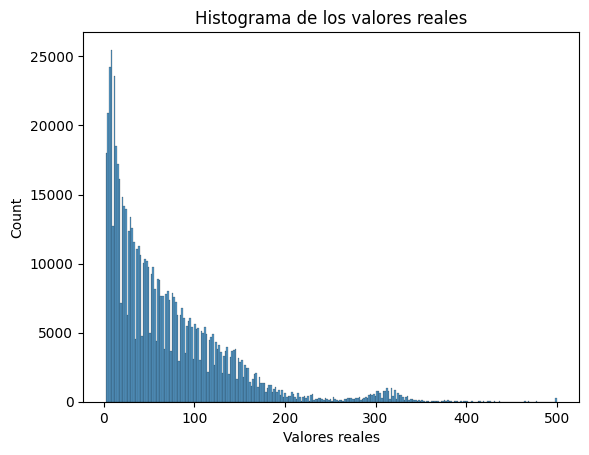

In [12]:
plot_dist(x_real_d)

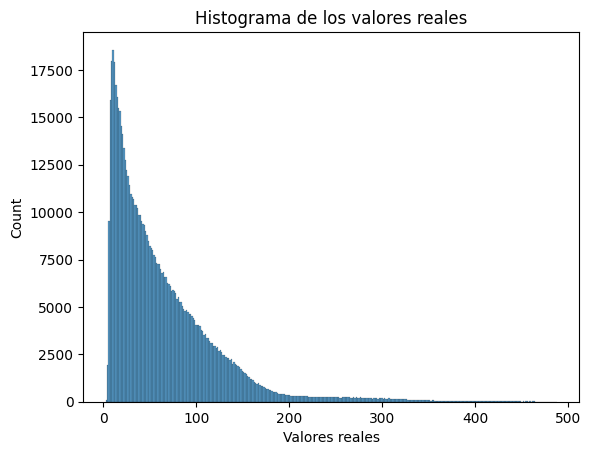

In [13]:
plot_dist(x_fake_d)

In [14]:

p_fault = 0.
p_noise = 0.25
base_data = add_missing_values(MetrLA(),
                                           p_fault=p_fault,
                                           p_noise=p_noise,
                                           min_seq=12,
                                           max_seq=12 * 4,
                                           seed=9101112)
print(base_data.dataframe().shape)

mask = base_data.mask.reshape(-1, 207)
known_values = base_data.eval_mask.reshape(-1, 207)
np_o_data = base_data.dataframe()[known_values].values.flatten()

(34272, 207)


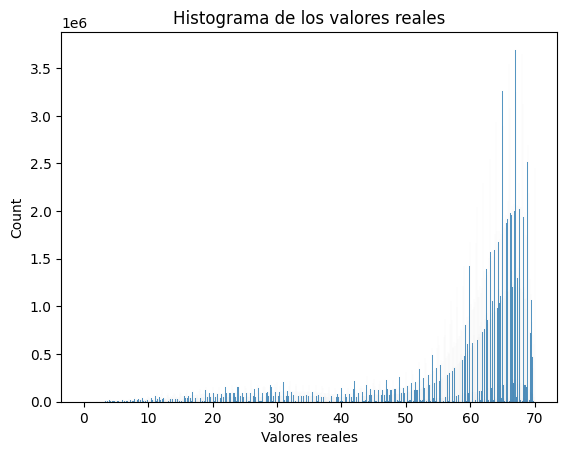

In [15]:
plot_dist(np_o_data)

# Estudio dist data

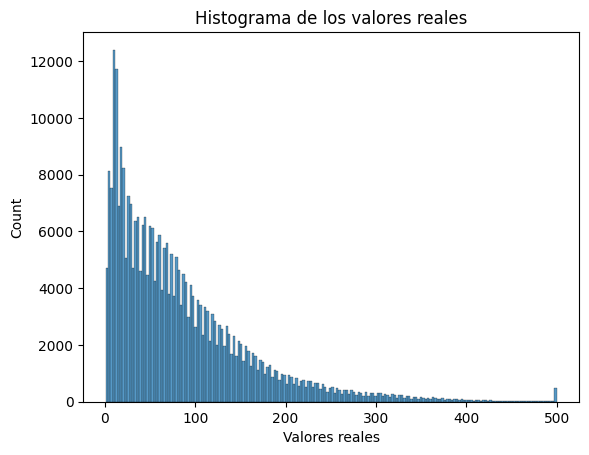

In [16]:
base_data = AirQuality(small=True)
mask = base_data.mask.reshape(-1, base_data.dataframe().shape[1])
known_values = base_data.eval_mask
total_data = base_data.dataframe().values
np_o_data = base_data.dataframe()[~mask].values.flatten()
plot_dist(total_data.flatten())

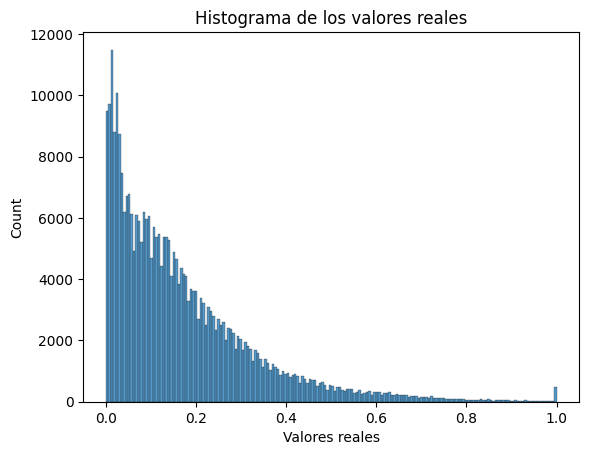

In [17]:
scaler = MinMaxScaler()
scaler.fit(total_data)
total_data = scaler.transform(total_data)
plot_dist(total_data.flatten())

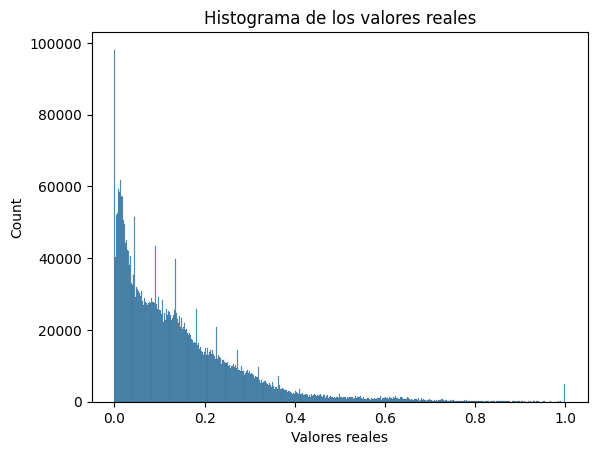

In [18]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.2_air-36.pkl')
plot_dist(x_real.cpu().numpy().reshape(-1, x_real.shape[-1]).flatten())

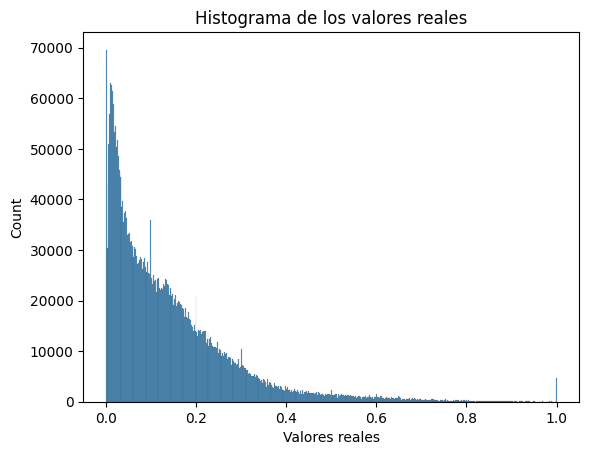

In [19]:
plot_dist(x_fake.cpu().numpy().reshape(-1, x_real.shape[-1]).flatten())

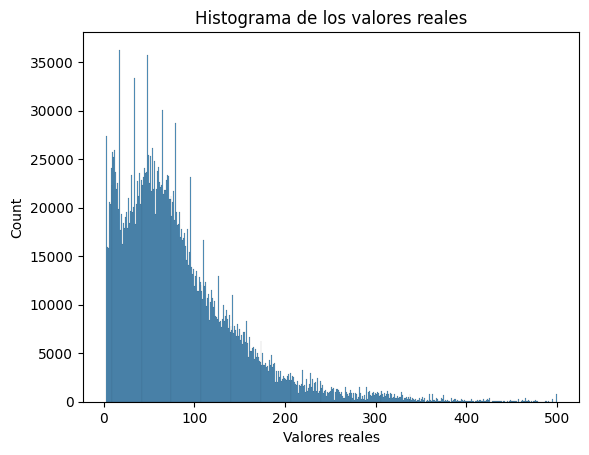

In [20]:
x_real_denorm = get_values_norm(dm.train_dataloader(), dm.get_normalizer())
plot_dist(x_real_denorm)

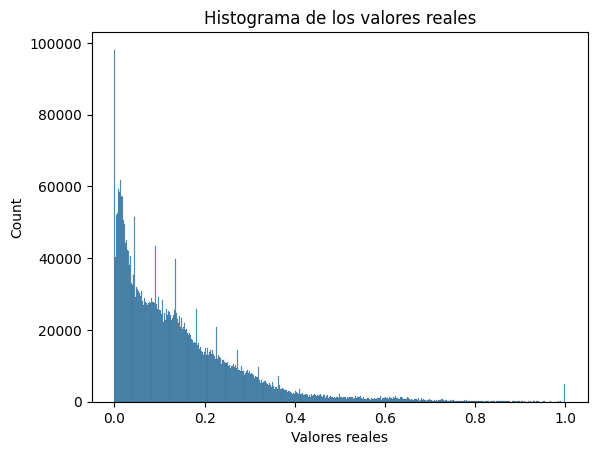

In [21]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.2_air-36.pkl')
plot_dist(x_real.cpu().numpy().flatten())

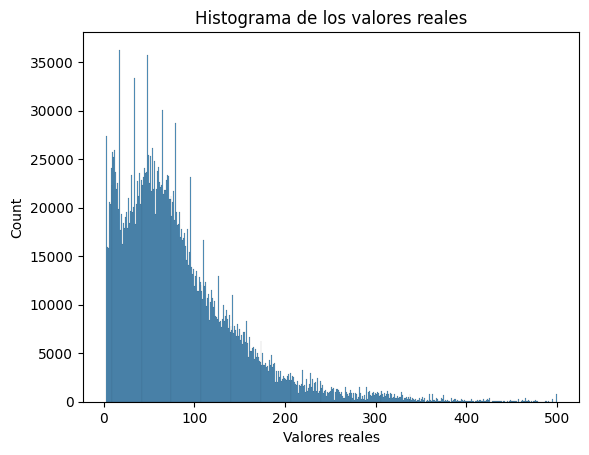

In [22]:
plot_dist(x_real_denorm)

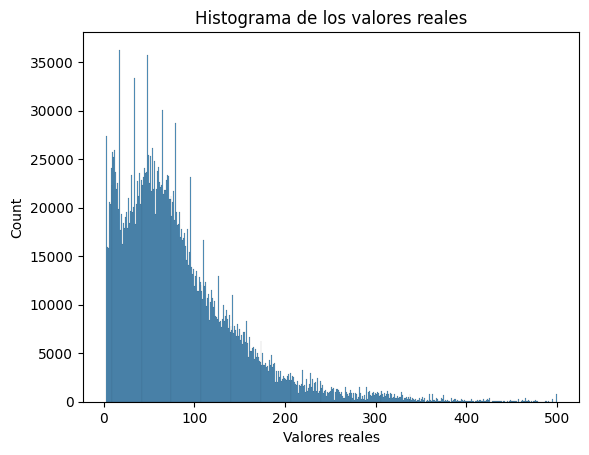

In [23]:
x_real_denorm = get_values_norm(dm.train_dataloader(), dm.get_normalizer())
plot_dist(x_real_denorm)

In [86]:
base_data = AirQuality(small=True)
mask = base_data.training_mask.reshape(-1, base_data.dataframe().shape[1])
known_values = base_data.eval_mask.reshape(-1, base_data.dataframe().shape[1])

print(base_data.dataframe().shape, mask.shape, known_values.shape)

(8759, 36) (8759, 36) (8759, 36)


In [87]:
print(sum(sum(mask)), sum(sum(known_values)))

237816 35737


In [89]:
x = np.logical_and(~mask, known_values)
x.sum()

35737

In [90]:
sum(sum(~mask))

77508

In [80]:
base_data.dataframe().values[mask]

array([138.,  89., 105., ..., 164., 244.,  94.], dtype=float32)

In [81]:
base_data.dataframe().values[known_values]

array([108., 101., 112., ..., 208., 178.,  88.], dtype=float32)

In [82]:
known_values

array([[False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [62]:
import torch

In [85]:
torch.logical_and(~torch.from_numpy(mask), torch.from_numpy(known_values)).sum()

tensor(35737)